In [460]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.formula.api as smf

# regex
import re

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc={'patch.edgecolor': 'black'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

&nbsp;

...

&nbsp;

---

# Analyzing Telomere Length Data from TeloFISH
---

## Mean Telomere Length analyses

### Visualizations

In [337]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
all_patients_df['telo data'] = all_patients_df['telo data'].map(literal_eval)

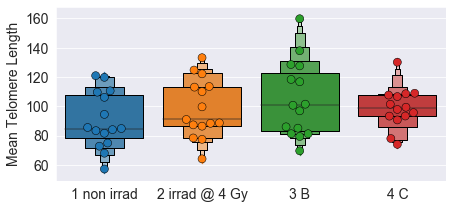

In [78]:
sns.set_style(rc= {'patch.edgecolor': 'black'})

fig = plt.figure(figsize=(7,3.2))
ax = sns.boxenplot(x='timepoint',y='telo means', data=all_patients_df,
                  linewidth=1,)
ax = sns.swarmplot(x='timepoint',y='telo means', data=all_patients_df, size=8,
                  linewidth=.5, edgecolor='black')

# ax.set_title("Mean Telomere Length (TeloFISH) per timepoint") 
ax.set_ylabel('Mean Telomere Length', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.tick_params(labelsize=14)
plt.savefig('../graphs/paper figures/main figs/all patient Mean telomere length means teloFISH.png', 
            dpi=400, bbox_inches = "tight")

In [206]:
all_patients_df.head()

,patient id,timepoint,telo data,telo means,Q1,Q2-3,Q4
0,1,1 non irrad,"[70.74301669292741, 91.86033510872664, 59.1284...",84.796483,1195,2225,1180
1,1,2 irrad @ 4 Gy,"[91.86033510872664, 119.31165592077517, 99.251...",90.975826,724,2350,1526
2,1,3 B,"[191.10982054566642, 141.48603338585482, 114.0...",116.779989,231,1457,2912
3,1,4 C,"[86.58100550477684, 139.3729078012595, 99.2504...",99.346299,372,2241,1987
4,2,1 non irrad,"[149.47242207268806, 104.23734697174298, 171.1...",119.773675,1166,2270,1164


### ANOVA, correlations, linear regressions

In [469]:
df = all_patients_df[all_patients_df['patient id'] != 13].copy()

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='telo means',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.05898000440859586


In [224]:
lin_reg_df = all_patients_df.pivot(index='patient id', columns='timepoint', values='telo means')
lin_reg_df = lin_reg_df.drop(13)
lin_reg_df['constant'] = 1

In [225]:
lin_reg_df.corr()

timepoint,1 non irrad,2 irrad @ 4 Gy,3 B,4 C,constant
timepoint,,,,,
1 non irrad,1.000000,0.947341,0.509322,0.401291,NaN
2 irrad @ 4 Gy,0.947341,1.000000,0.620616,0.400194,NaN
3 B,0.509322,0.620616,1.000000,0.534244,NaN
4 C,0.401291,0.400194,0.534244,1.000000,NaN
constant,NaN,NaN,NaN,NaN,NaN


In [506]:
x_names = [['1 non irrad'], ['1 non irrad', '2 irrad @ 4 Gy'],]
#            ['1 non irrad', '2 irrad @ 4 Gy', '3 B']]   
y_name = '4 C'

df_list = []

for x_name in x_names:
    x = lin_reg_df[x_name].values.reshape(-1, len(x_name))
    y = lin_reg_df['4 C'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")
    
    df_list.append([', '.join(x_name), '4 C', round(regression.score(x, y), 4)])

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.1610
Linear regression for ['1 non irrad', '2 irrad @ 4 Gy'] vs. 4 C:
R2 is 0.1649


In [507]:
LM_metrics = pd.DataFrame(df_list, columns=['Model features', 'Target', 'Linear regression R2 score'])
LM_metrics['Model features'] = LM_metrics['Model features'].astype('str')

In [513]:
LM_metrics

,Model features,Target,Linear regression R2 score
0,1 non irrad,4 C,0.1610
1,"1 non irrad, 2 irrad @ 4 Gy",4 C,0.1649


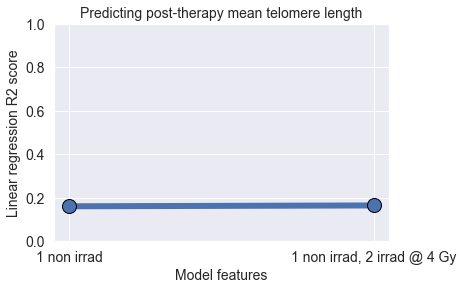

In [620]:
import matplotlib.patheffects as pe

sns.set_style(rc= {'patch.edgecolor': 'black'})
sns.set_color_codes()

fig = plt.figure(figsize=(6,4))
ax = sns.lineplot(x='Model features', y='Linear regression R2 score', data=LM_metrics, 
                  linewidth=6, sort=False, legend=False, marker='o', 
                  **{'markersize':14, 
                     'mec':'black', 
                     'mew':1})
                       


ax.set_ylabel('Linear regression R2 score', fontsize=14)
ax.set_xlabel('Model features', fontsize=14,)

plt.xticks(fontsize=14,)
plt.yticks(fontsize=14)
plt.ylim(0,1)
plt.title('Predicting post-therapy mean telomere length', fontsize=14)

plt.savefig('../graphs/paper figures/main figs/linear regression metrics Mean telomere length means teloFISH.png', 
            dpi=400, bbox_inches = "tight")

In [7]:
# more indepth stats

# target = lin_reg_df['4 C']
# linear_m = sm.OLS(endog=target, exog=lin_reg_df[['1 non irrad', '2 irrad @ 4 Gy', 'constant']], missing='drop')
# results = linear_m.fit()
# results.summary()

## Individual Telomere Length analyses

In [338]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')

### Visualizations

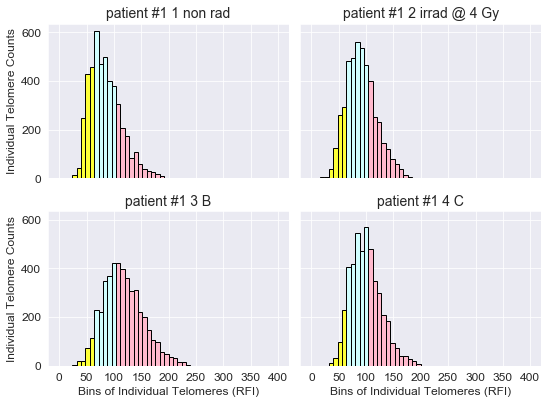

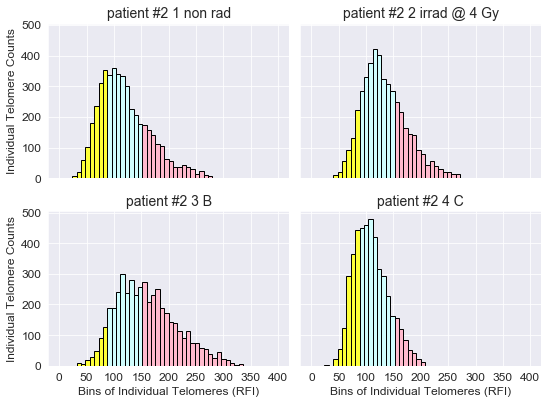

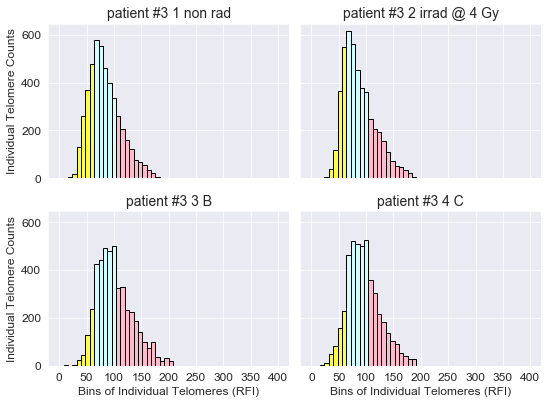

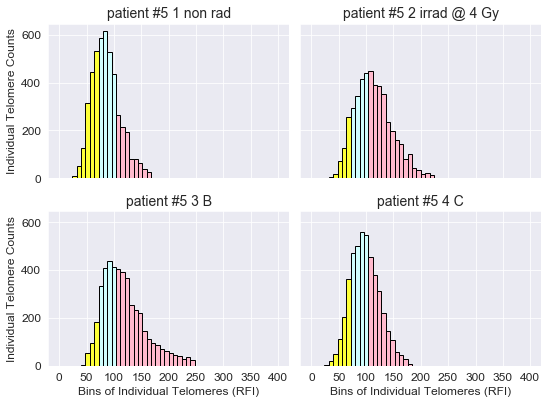

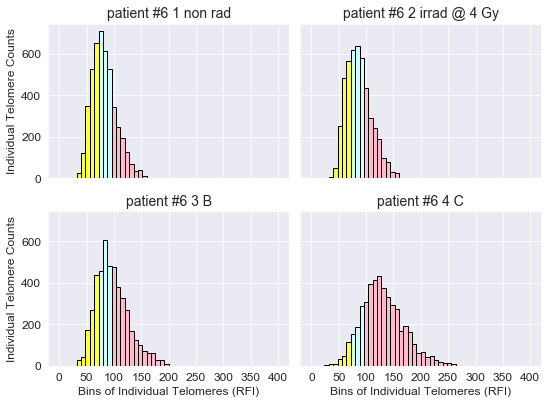

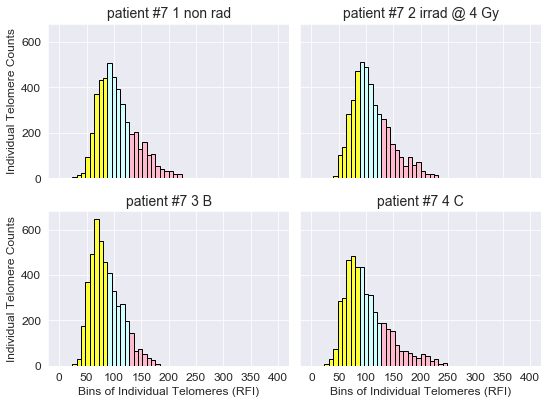

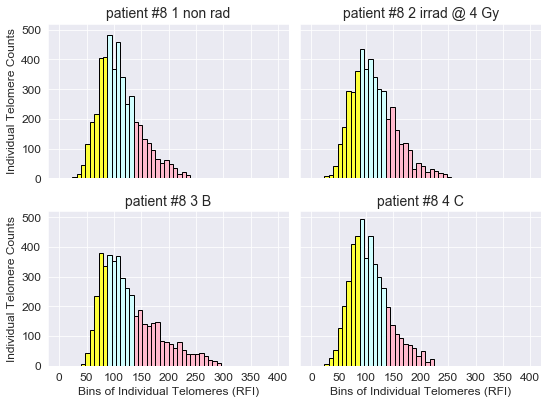

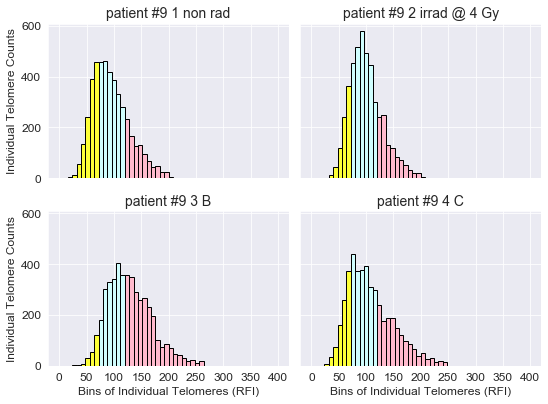

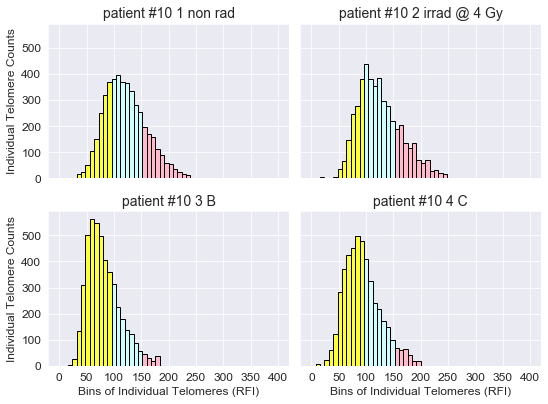

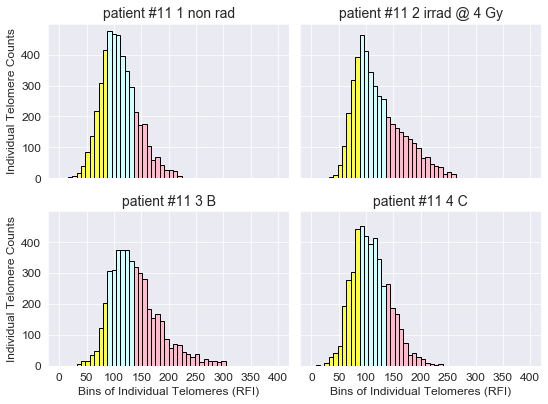

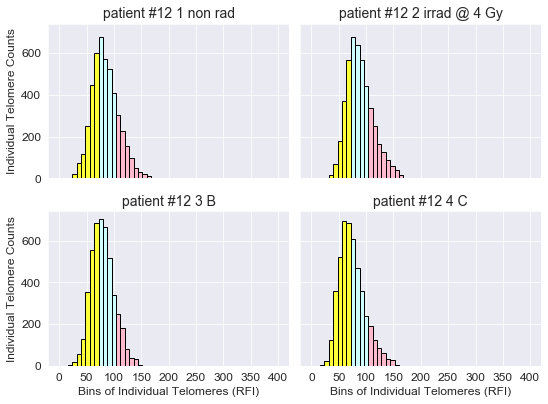

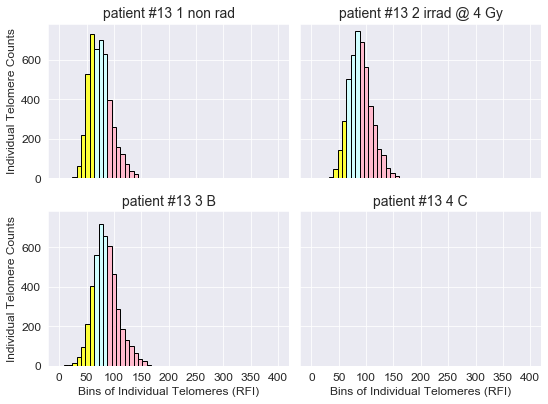

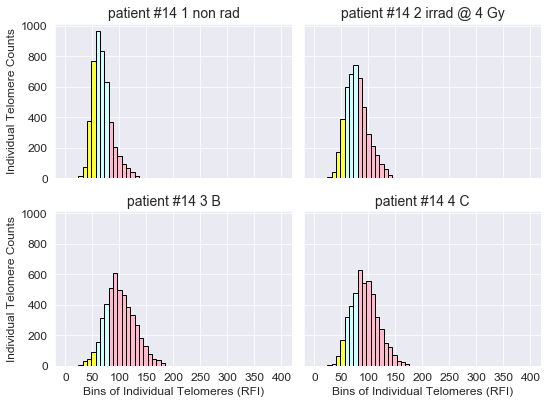

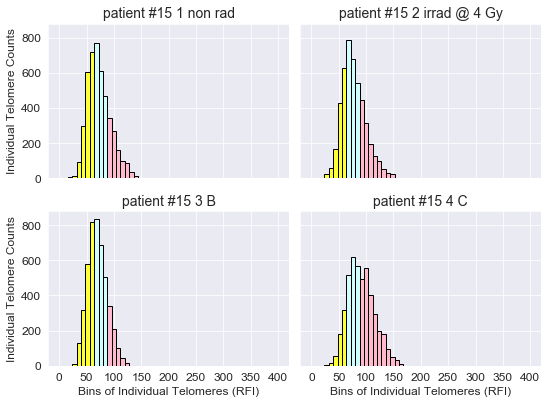

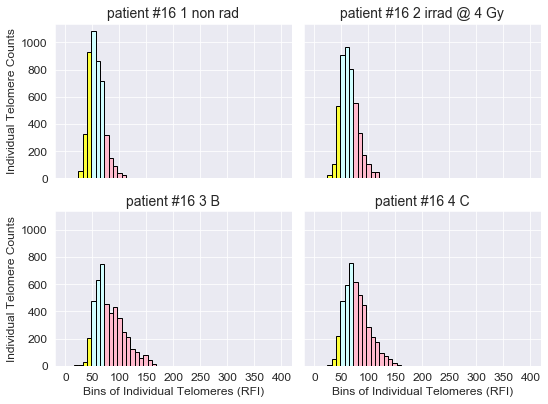

In [106]:
# graphing individual telomeres per individual per timepoint, personal telomere length dynamics as fxn of radiotherapy
patient_ids = list(exploded_telos_all_patients_df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=exploded_telos_all_patients_df.copy(), 
                          groupby='patient id', 
#                           iterable=[patient_ids[1]],
                          iterable=patient_ids,
                          n_bins=50,
                          znorm=False)

### Statistics

#### Linear Mixed Effect Modeling of telomere means

In [405]:
# removing spaces from column names for linear model (doesn't work w/ spaces)
df = exploded_telos_all_patients_df.copy()
df.rename({'individual telomeres': 'individual_telomeres',
           'patient id': 'patient_id'}, axis=1, inplace=True)

# encoding timepoint as numerical, log normalizing individual telos
label_encoder = preprocessing.LabelEncoder()
df['timepoint_encoded'] = label_encoder.fit_transform(df['timepoint'])
df['log_individ_telos'] = np.log(df['individual_telomeres'])

# df = df.groupby(by=['patient_id', 'timepoint']).agg('mean').reset_index()

In [469]:
df = all_patients_df[all_patients_df['patient id'] != 13].copy()

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='telo means',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.05898000440859586


In [413]:
# regressing time onto individual telos w/ random intercepts for patients

model = smf.mixedlm("individual_telomeres ~ timepoint_encoded", 
                    df, 
#                     re_formula='timepoint_encoded',
                    groups=df['patient_id']) 

results = model.fit(method='powell')
results.summary()
results.pvalues[0:4]

Intercept            4.887136e-108
timepoint_encoded     0.000000e+00
Group Var             6.910804e-03
dtype: float64

#### Post-hoc Tukey HSD 

In [414]:
obj = pairwise_tukeyhsd(df['individual_telomeres'], df['timepoint'])
obj.summary()

group1,group2,meandiff,lower,upper,reject
1 non irrad,2 irrad @ 4 Gy,8.297,7.7796,8.8144,True
1 non irrad,3 B,14.4682,13.9509,14.9856,True
1 non irrad,4 C,8.7314,8.2049,9.258,True
2 irrad @ 4 Gy,3 B,6.1713,5.6539,6.6886,True
2 irrad @ 4 Gy,4 C,0.4344,-0.0921,0.961,False
3 B,4 C,-5.7368,-6.2633,-5.2103,True


In [28]:
# test_df = exploded_telos_all_patients_df.copy()
# for col in test_df.columns:
#     test_df.rename({col: col.replace(' ', '_')}, axis=1, inplace=True)
# test_df = test_df[test_df['patient_id'] != 13].copy()

### Graphing all patients overall individual telomere length distributions

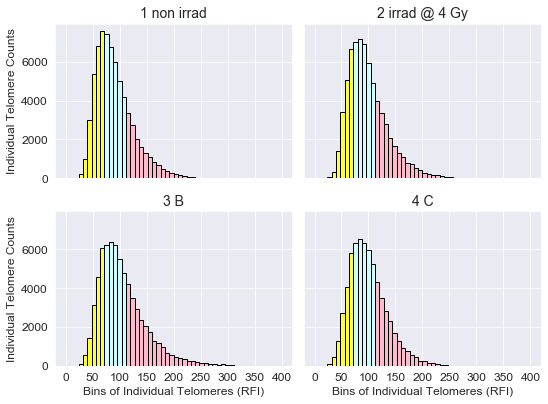

In [113]:
# graphing individual telomeres per timepoint, overall cohort telomere length dynamics as fxn of radiotherapy
df = exploded_telos_all_patients_df.copy()

patient_ids = list(df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=df, 
                          groupby='timepoint', 
                          n_bins=50,
                          znorm=False)

### Graphing cluster 1 patients' individual telomere length distributions

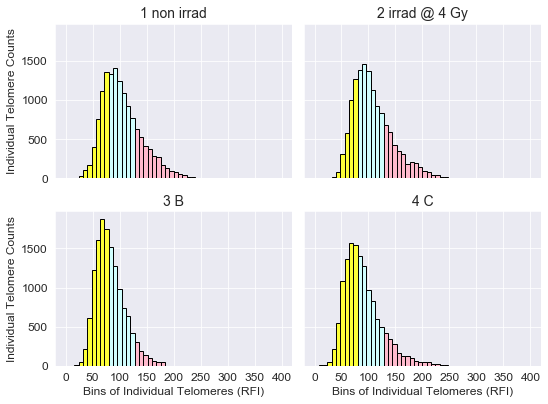

In [108]:
# parsing overall individual telomere dist for cluster 1 
df = exploded_telos_all_patients_df[exploded_telos_all_patients_df['patient id'].isin([7,10,12])].copy()

patient_ids = list(df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=df, 
                          groupby='timepoint', 
                          n_bins=50,
                          znorm=False)

### Graphing cluster 2 patients' individual telomere length distributions

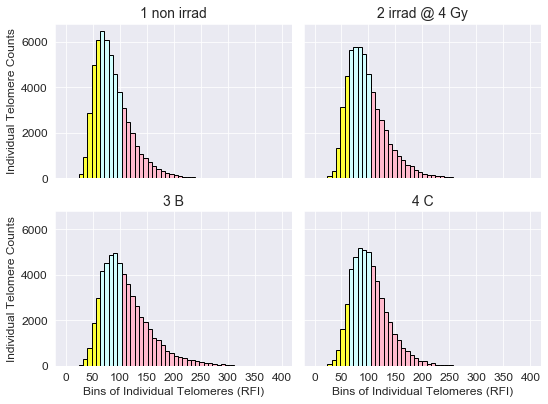

In [109]:
# parsing overall individual telomere dist for cluster 2
df = exploded_telos_all_patients_df[~exploded_telos_all_patients_df['patient id'].isin([7,10,12])].copy()

patient_ids = list(df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=df, 
                          groupby='timepoint', 
                          n_bins=50,
                          znorm=False)

### Kruskal wallis + Z-norm + KS-test w/ bonferroni correction for shape differences between timepoints

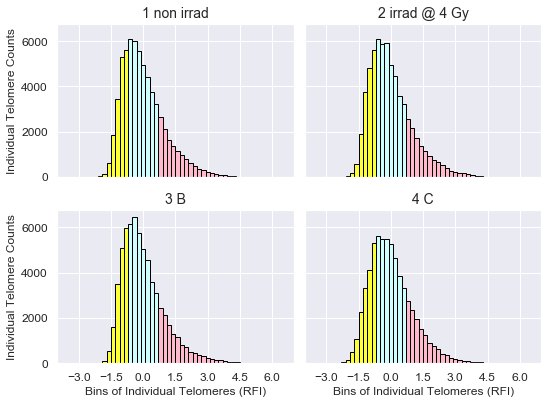

In [478]:
df = exploded_telos_all_patients_df[exploded_telos_all_patients_df['patient id'] != 13].copy()
z_norm = trp.z_norm_individual_telos(exploded_telos_df=df)

# z-norming distributions of individual telomeres per timepoint to enable statistical analysis between
# shapes of overall cohort telomere length dynamics
time_points = list(z_norm['timepoint'].unique())
trp.histogram_plot_groups(x='z-norm_individual_telos', 
                          data=z_norm, 
                          groupby='timepoint', 
                          n_bins=50, 
                          znorm=True)

In [486]:
df = exploded_telos_all_patients_df[exploded_telos_all_patients_df['patient id'] != 13].copy()
target='individual telomeres'

g_1 = df[df['timepoint'] == '1 non irrad'][target]
g_2 = df[df['timepoint'] == '2 irrad @ 4 Gy'][target]
g_3 = df[df['timepoint'] == '3 B'][target]
g_4 = df[df['timepoint'] == '4 C'][target]
statistic, p_value = stats.kruskal(g_1, g_2, g_3, g_4)

print(f'KRUSKAL-WALLIS TEST FOR SIG BETWEEN DISTRIBUTIONS: H STAT: {statistic} P VALUE: {p_value}')

KRUSKAL-WALLIS TEST FOR SIG BETWEEN DISTRIBUTIONS: H STAT: 4417.2500567902225 P VALUE: 0.0


In [479]:
# we see a diff. in shape between all timepoints, as well we see a sig diff between irrad @ 4 Gy & 4 C shapes,
# though mean was the same (ANOVA)

test = ks_2samp
test_name = 'Kolmogorov-Smirnov'
timept_pairs, row = trp.eval_make_test_comparisons(df=z_norm, target='z-norm_individual_telos',
                                                   test=test, test_name=test_name,)

KS_stats_df = pd.DataFrame(row, columns=[test_name, 'timepoint 1', 'timepoint 2', 
                                         'p value', 'KS statistic'])

# iterate for between patients as well? would just be loop using above fxn, passing df per patient

Kolmogorov-Smirnov | 1 non irrad vs 2 irrad @ 4 Gy P-VALUE: 0.07238870179647408 KS-STAT 0.007173913043478253
Kolmogorov-Smirnov | 1 non irrad vs 3 B P-VALUE: 2.3151814439595848e-05 KS-STAT 0.013276397515527949
Kolmogorov-Smirnov | 1 non irrad vs 4 C P-VALUE: 8.402756230273283e-16 KS-STAT 0.023431677018633537
Kolmogorov-Smirnov | 2 irrad @ 4 Gy vs 3 B P-VALUE: 6.233890108982835e-06 KS-STAT 0.014021739130434793
Kolmogorov-Smirnov | 2 irrad @ 4 Gy vs 4 C P-VALUE: 5.758230093941806e-19 KS-STAT 0.025729813664596257
Kolmogorov-Smirnov | 3 B vs 4 C P-VALUE: 1.341631992664129e-27 KS-STAT 0.031149068322981366


In [480]:
# bonferroni pvalue correction to KS-tests
bonferroni_corr = multipletests(KS_stats_df['p value'], method='bonferroni')

# assigning elements of correction to objects
true_false_reject_hyp, pval_corr = bonferroni_corr[0], bonferroni_corr[1]
alpha_c_sidak, alpha_c_bonf = bonferroni_corr[2], bonferroni_corr[3]

# df from vals
bonf_corr_df = pd.DataFrame({'Reject null?': true_false_reject_hyp, 'Bonferroni corrected p values': pval_corr,
                             'Sidak corrected alpha': alpha_c_sidak, 'Bonferroni corrected alpha': alpha_c_bonf})

In [481]:
# merging bonferroni pvals w/ original KS stats & saving to file
KS_stats_df[['Bonferroni corrected p values', 'Reject null?']] = bonf_corr_df[['Bonferroni corrected p values', 
                                                                               'Reject null?']]
display(KS_stats_df)

trp.df_to_png(df=KS_stats_df, 
              path='../graphs/paper figures/supp figs/KS test between overall shapes of individ telo dist.png')

,Kolmogorov-Smirnov,timepoint 1,timepoint 2,p value,KS statistic,Bonferroni corrected p values,Reject null?
0,Kolmogorov-Smirnov,1 non irrad,2 irrad @ 4 Gy,7.238870e-02,0.007174,4.343322e-01,False
1,Kolmogorov-Smirnov,1 non irrad,3 B,2.315181e-05,0.013276,1.389109e-04,True
2,Kolmogorov-Smirnov,1 non irrad,4 C,8.402756e-16,0.023432,5.041654e-15,True
3,Kolmogorov-Smirnov,2 irrad @ 4 Gy,3 B,6.233890e-06,0.014022,3.740334e-05,True
4,Kolmogorov-Smirnov,2 irrad @ 4 Gy,4 C,5.758230e-19,0.025730,3.454938e-18,True
5,Kolmogorov-Smirnov,3 B,4 C,1.341632e-27,0.031149,8.049792e-27,True


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


### Feature Engineering Short/Long Individual Telomeres

In [293]:
melted_all_patients_df = pd.melt(
    all_patients_df,
    id_vars = [col for col in all_patients_df.columns if col != 'Q1' and col != 'Q2-3' and col != 'Q4'],
    var_name='relative Q',
    value_name='Q freq counts')

melted_all_patients_df['Q freq counts'] = melted_all_patients_df['Q freq counts'].astype('float64')

In [294]:
def change_qcol_descrip(row):
    if row == 'Q1':
        return 'short'
    elif row == 'Q2-3':
        return 'medium'
    elif row == 'Q4':
        return 'long'

melted_all_patients_df['relative Q'] = melted_all_patients_df['relative Q'].apply(lambda row: change_qcol_descrip(row))

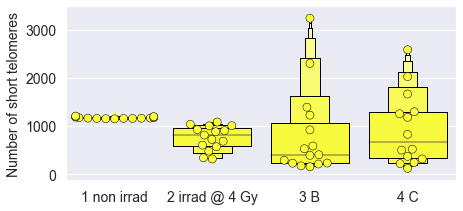

In [221]:
sns.set_style(rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","medium":"#d0fefe","long":"#ffbacd"}

fig = plt.figure(figsize=(7,3.2))
ax = sns.boxenplot(x='timepoint',y='Q1', data=all_patients_df,
                  linewidth=1, color="#fdff38", saturation=.95)
ax = sns.swarmplot(x='timepoint',y='Q1', data=all_patients_df, size=8,
                  linewidth=.5, edgecolor='black', color="#fdff38")

# ax.set_title("Mean Telomere Length (TeloFISH) per timepoint") 
ax.set_ylabel('Number of short telomeres', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.tick_params(labelsize=14)
plt.savefig('../graphs/paper figures/main figs/all patient Number of short telomeres teloFISH.png', 
            dpi=400, bbox_inches = "tight")

In [536]:
all_patients_df.head()

,patient id,timepoint,telo data,telo means,Q1,Q2-3,Q4
0,1,1 non irrad,"[70.74301669292741, 91.86033510872664, 59.1284...",84.796483,1195,2225,1180
1,1,2 irrad @ 4 Gy,"[91.86033510872664, 119.31165592077517, 99.251...",90.975826,724,2350,1526
2,1,3 B,"[191.10982054566642, 141.48603338585482, 114.0...",116.779989,231,1457,2912
3,1,4 C,"[86.58100550477684, 139.3729078012595, 99.2504...",99.346299,372,2241,1987
4,2,1 non irrad,"[149.47242207268806, 104.23734697174298, 171.1...",119.773675,1166,2270,1164


In [534]:
df = all_patients_df[all_patients_df['patient id'] != 13].copy()

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='Q1',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.19956991528083137


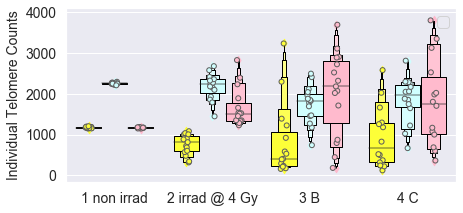

In [295]:
# ax = sns.set(font_scale=1)
fig = plt.figure(figsize=(7,3.2))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
# palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}
palette ={"short":"#fdff38","medium":"#d0fefe","long":"#ffbacd"}


ax = sns.boxenplot(x='timepoint', y='Q freq counts', hue='relative Q', data=melted_all_patients_df, palette=palette,
             linewidth=2, saturation=5, color="black", )
ax = sns.stripplot(x='timepoint', y='Q freq counts', hue='relative Q', data=melted_all_patients_df, palette=palette,
             linewidth=1, color="black", dodge=True, )

ax=fig.gca()
# ax.set_title('Changes in Distribution Individual Telos Relative to Pre-Rad Therapy Time point', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Individual Telomere Counts', fontsize=14)
ax.tick_params(labelsize=14)


plt.legend('', '')
plt.savefig('../graphs/paper figures/supp figs/counting # short telos.png', dpi=400,
           bbox_inches='tight')

### Linear regression short telo counts

In [314]:
q_lr_df = all_patients_df.pivot(index='patient id', columns='timepoint', values='Q1')
q_lr_df.drop(13, inplace=True)
q_lr_df['constant'] = 1

q_lr_df.head()

timepoint,1 non irrad,2 irrad @ 4 Gy,3 B,4 C,constant
patient id,,,,,
1,1195.0,724.0,231.0,372.0,1
2,1166.0,481.0,292.0,1182.0,1
3,1190.0,1006.0,407.0,503.0,1
5,1159.0,319.0,234.0,521.0,1
6,1188.0,929.0,587.0,124.0,1


In [502]:
x_names = [['1 non irrad'], ['1 non irrad', '2 irrad @ 4 Gy'],] 
y_name = '4 C'

df_list = []

for x_name in x_names:
    name = x_name[0]
    
    x = q_lr_df[x_name].values.reshape(-1, len(x_name))
    y = q_lr_df['4 C'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")
    
    df_list.append([', '.join(x_name), '4 C', round(regression.score(x, y), 4)])

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.4328
Linear regression for ['1 non irrad', '2 irrad @ 4 Gy'] vs. 4 C:
R2 is 0.5536


In [503]:
qLM_metrics = pd.DataFrame(df_list, columns=['Model features', 'Target', 'Linear regression R2 score'])
qLM_metrics.head()

,Model features,Target,Linear regression R2 score
0,1 non irrad,4 C,0.4328
1,"1 non irrad, 2 irrad @ 4 Gy",4 C,0.5536


In [504]:
qLM_metrics['Model features'] = qLM_metrics['Model features'].astype('str')

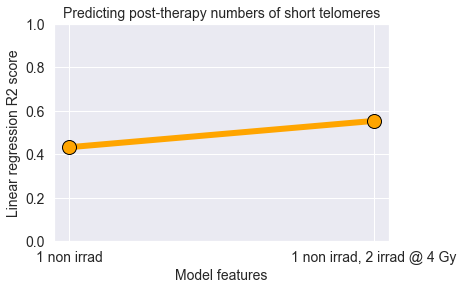

In [617]:
sns.set_style(rc= {'patch.edgecolor': 'black'})
sns.set_color_codes()

fig = plt.figure(figsize=(6,4))
ax = sns.lineplot(x='Model features', y='Linear regression R2 score', data=qLM_metrics, 
                  linewidth=6, sort=False, hue='Target', palette={'4 C':'orange'}, legend=False, marker='o', 
                  **{'markersize':14, 
                     'mec':'black', 
                     'mew':1})

ax.set_ylabel('Linear regression R2 score', fontsize=14)
ax.set_xlabel('Model features', fontsize=14,)
# ax.tick_params(labelsize=14,)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,1)
plt.title('Predicting post-therapy numbers of short telomeres', fontsize=14)

plt.savefig('../graphs/paper figures/main figs/linear regression metrics numbers short telos teloFISH.png', 
            dpi=400, bbox_inches = "tight")

# Analyzing Telomere Length Data from qPCR (Aidan/Lynn)
---

In [19]:
all_qPCR_df = pd.read_csv('../data/qPCR telo data/all_qPCR_df.csv')

Text(0.5, 0, 'timepoint')

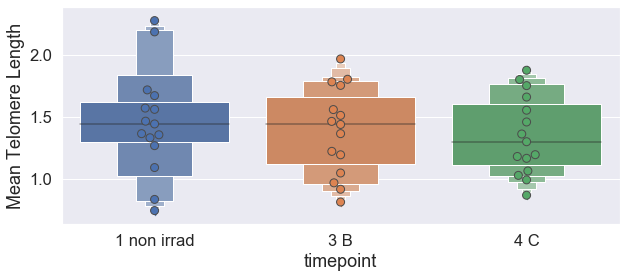

In [43]:
fig = plt.figure(figsize=(10,4))
ax = sns.set(font_scale = 1.5)

ax= sns.boxenplot(x='timepoint', y='telo means qPCR', data=all_qPCR_df,
             linewidth=1)
ax= sns.swarmplot(x='timepoint', y='telo means qPCR', data=all_qPCR_df,
             linewidth=1, size=8)

# ax.set_title("Mean Telomere Length (qPCR) Per Timepoint") 
ax.set_ylabel('Mean Telomere Length')
ax.set_xlabel('timepoint')
# plt.savefig('../graphs/telomere length/all patient telomere length means qPCR.png', dpi=400)

## Correlations and Linear Regressions 

In [21]:
pivot_qPCR_df = all_qPCR_df.pivot(index='patient id', columns='timepoint', values='telo means qPCR')
pivot_qPCR_df['constant'] = 1
pivot_qPCR_df.corr()

timepoint,1 non irrad,3 B,4 C,constant
timepoint,,,,
1 non irrad,1.000000,0.765298,0.769699,NaN
3 B,0.765298,1.000000,0.880080,NaN
4 C,0.769699,0.880080,1.000000,NaN
constant,NaN,NaN,NaN,NaN


In [22]:
x_names = [['1 non irrad'], ['1 non irrad', '3 B']]
y_name = '4 C'

for x_name in x_names:
    x = pivot_qPCR_df[x_name].values.reshape(-1, len(x_name))
    y = pivot_qPCR_df['4 C'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.5924
Linear regression for ['1 non irrad', '3 B'] vs. 4 C:
R2 is 0.7969


In [23]:
# more indepth stats
# target = pivot_qPCR_df['4 C']
# linear_m = sm.OLS(endog=target, exog=pivot_qPCR_df[['1 non irrad', 'constant']], missing='drop')
# results = linear_m.fit()
# print(results.summary())

In [24]:
# linear_m2 = sm.OLS(endog=target, exog=pivot_qPCR_df[['1 non irrad', '3 B', 'constant']], missing='drop')
# results2 = linear_m2.fit()
# print(results2.summary())

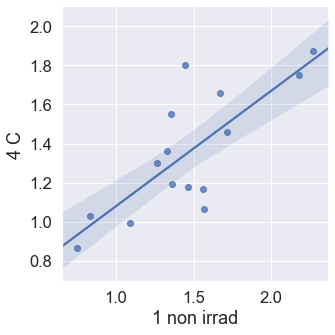

In [25]:
sns.lmplot(x='1 non irrad', y='4 C', data=pivot_qPCR_df, fit_reg=True)

## Statistics 

In [26]:
# conducting one-way ANOVA for mean telomere length
# need change to repeated measures 

df = all_qPCR_df
g_1 = df[df['timepoint'] == '1 non irrad']['telo means qPCR']
g_2 = df[df['timepoint'] == '3 B']['telo means qPCR']
g_3 = df[df['timepoint'] == '4 C']['telo means qPCR']
stats.f_oneway(g_1, g_2, g_3)

F_onewayResult(statistic=0.33940643369655527, pvalue=0.714128148014912)

# Analyzing Chromosome Aberration Data from dGH
---

In [448]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')
general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False, adjust_clonality=True))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

In [449]:
melt_aberrations = pd.melt(cleaned_chr_df, id_vars=['patient id', 'timepoint'],
                           var_name='aberration type', value_name='count per cell')

melt_aberrations['count per cell'] = melt_aberrations['count per cell'].astype('int64')
melt_aberrations['aberration type'] = melt_aberrations['aberration type'].astype('str')

## Visualizing Chromosome Rearrangements

In [29]:
# melt_aberrations_chr_only = melt_aberrations[~melt_aberrations['aberration type'].isin(['# sub-telo SCEs', 'tricentrics',
#                                                                                         '# dicentrics', '# translocations',
#                                                                                         '# sat associations', 'cell number'])].copy()

# ax = sns.set(font_scale=2)
# ax = sns.catplot(y='aberration type', x='count per cell', hue='chromosome', 
#                  col='timepoint', col_wrap=2, 
#                  data=melt_aberrations_chr_only, kind='bar', height=7, aspect=1.5, orient="h",)

# ax.set_ylabels('')
# ax.set_xlabels('average count per cell')

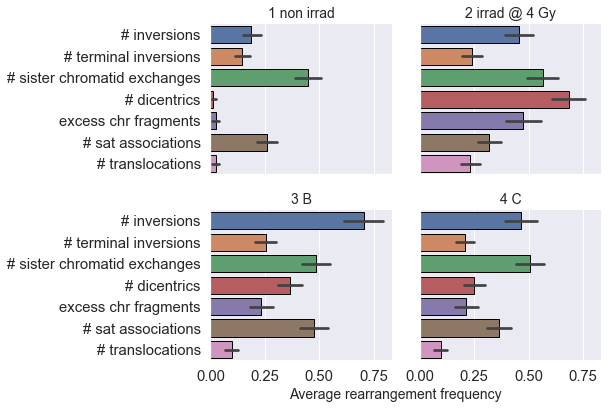

In [625]:
df = melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'].copy()
df.rename({'timepoint':'Time point'}, axis=1, inplace=True)

ax = sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
# ax = sns.set(font_scale=1.35)
ax = sns.catplot(y='aberration type', x='count per cell',
                 col='Time point', col_wrap=2,  
                 data=df, 
                 kind='bar', height=3., aspect=1.5, orient="h",)

fontsize=14

ax.set_ylabels('', fontsize=fontsize)
ax.set_xlabels('', fontsize=fontsize)
plt.xlabel('Average rearrangement frequency', horizontalalignment='right', x=0.45,
           fontsize=14)

axes = ax.axes.flatten()
axes[0].set_title("1 non irrad", fontsize=fontsize)
axes[1].set_title("2 irrad @ 4 Gy", fontsize=fontsize)
axes[2].set_title("3 B", fontsize=fontsize)
axes[3].set_title("4 C", fontsize=fontsize)

ax.savefig('../graphs/paper figures/main figs/all patients rearrangements.png', dpi=400,
          bbox_inches = "tight")

In [648]:
inv = melt_aberrations[melt_aberrations['aberration type'] == '# inversions'].copy()

In [649]:
inv.head()

,patient id,timepoint,aberration type,count per cell
0,1,1 non irrad,# inversions,0
1,1,1 non irrad,# inversions,0
2,1,1 non irrad,# inversions,0
3,1,1 non irrad,# inversions,0
4,1,1 non irrad,# inversions,0


Text(0.5, 1.0, 'Inversions')

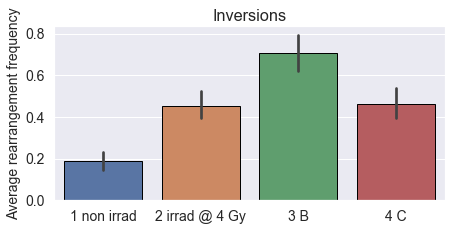

In [659]:
inv.rename({'timepoint':'Time point'}, axis=1, inplace=True)

plt.figure(figsize=(7,3.2))

ax = sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
ax = sns.barplot(x='Time point', y='count per cell', data=inv)

fontsize=14

ax.set_ylabel('', fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
plt.ylabel('Average rearrangement frequency', fontsize=14)
plt.title('Inversions')


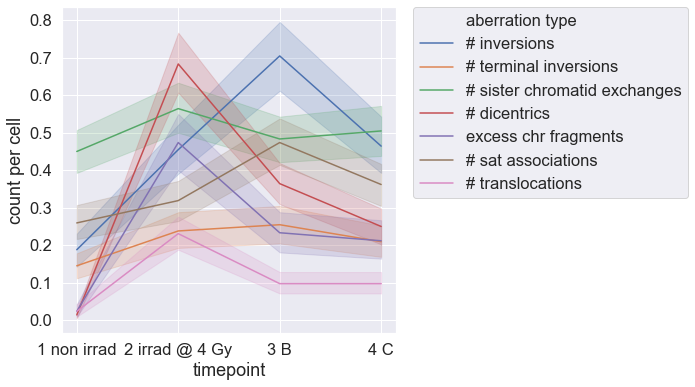

In [31]:
plt.figure(figsize=(6,6))
ax=sns.set(font_scale=1.5)
ax = sns.lineplot(x='timepoint', y='count per cell', data=melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'],
                  hue='aberration type', 
#                   palette=sns.color_palette("terrain", melt_aberrations['aberration type'].nunique()),
                  )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

## Statistics Chromosome Rearrangements

In [371]:
label_encoder = preprocessing.LabelEncoder()
melt_aberrations['timepoint_encoded'] = label_encoder.fit_transform(melt_aberrations['timepoint'])

In [419]:
# melt_aberrations.rename({'patient id': 'patient_id',
#                          'count per cell' : 'count_per_cell'}, axis=1, inplace=True)
# for aberr in list(melt_aberrations['aberration type'].unique()):
#     if aberr != '# terminal SCEs':

#         copy = melt_aberrations[melt_aberrations['aberration type'] == aberr].copy()
#         test = copy.groupby(by=['patient_id', 'timepoint', 
#                                 'timepoint_encoded', 'aberration type']).agg('mean').reset_index()

#         model = smf.mixedlm("count_per_cell ~ timepoint_encoded", 
#                             test, 
#                             re_formula='timepoint_encoded',
#                             groups=test['patient_id']
#                            ) 

#         results = model.fit()
#         # results.summary()
#         print(aberr)
# #         print(results.pvalues[1:4])
#         print(results.pvalues[1])
#         print('\n')

In [637]:
inv = melt_aberrations[melt_aberrations['aberration type'] == '# inversions'].copy()
inv.rename({'aberration type':'aberration_type',
            'count per cell':'count_per_cell',
            'patient id':'patient_id'}, axis=1, inplace=True)

In [646]:
from statsmodels.stats.anova import AnovaRM

results = AnovaRM(inv, 'count_per_cell', 'patient_id', within=['timepoint'], aggregate_func='mean').fit()
# pvalue
print(results.anova_table['Pr > F'][0])

2.3593983783857947e-16


In [661]:
from statannot import add_stat_annotation

(<matplotlib.axes._subplots.AxesSubplot at 0x145470950>,
 [{'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '1 non irrad',
   'box2': '2 irrad @ 4 Gy'},
  {'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '2 irrad @ 4 Gy',
   'box2': '3 B'},
  {'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '3 B',
   'box2': '4 C'},
  {'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '1 non irrad',
   'box2': '3 B'},
  {'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '1 non irrad',
   'box2': '4 C'}])

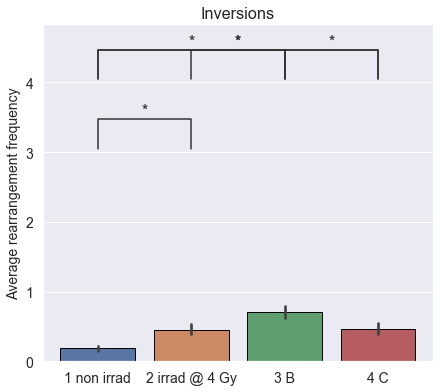

In [675]:
inv.rename({'timepoint':'Time point'}, axis=1, inplace=True)

df = inv
x = 'Time point'
y = 'count per cell'

plt.figure(figsize=(7,6.2))

ax = sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
ax = sns.barplot(x=x, y=y, data=df)

fontsize=14

ax.set_ylabel('', fontsize=fontsize)
ax.set_xlabel('', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
plt.ylabel('Average rearrangement frequency', fontsize=14)
plt.title('Inversions')

box_pairs = [
    (('1 non irrad'), ('2 irrad @ 4 Gy')),
    (('1 non irrad'), ('3 B')),
    (('1 non irrad'), ('4 C')),
    (('2 irrad @ 4 Gy'), ('3 B')),
    (('3 B'), ('4 C')),
]

pvalues = [0.04, 0.04, 0.04, 0.04, 0.04]

add_stat_annotation(ax, plot='barplot', data=df, x=x, y=y, 
                    box_pairs=box_pairs, 
                    order=['1 non irrad', '2 irrad @ 4 Gy', '3 B', '4 C'],
                    perform_stat_test=False, pvalues=pvalues,
                    line_height=0.50,
                    test=None, text_format='star', loc='inside', verbose=False, fontsize=16)

In [676]:
inv.head()

,patient id,Time point,aberration type,count per cell
0,1,1 non irrad,# inversions,0
1,1,1 non irrad,# inversions,0
2,1,1 non irrad,# inversions,0
3,1,1 non irrad,# inversions,0
4,1,1 non irrad,# inversions,0


(<matplotlib.axes._subplots.AxesSubplot at 0x143f048d0>,
 [{'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '1 non irrad',
   'box2': '2 irrad @ 4 Gy'},
  {'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '2 irrad @ 4 Gy',
   'box2': '3 B'},
  {'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '3 B',
   'box2': '4 C'},
  {'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '1 non irrad',
   'box2': '3 B'},
  {'pvalue': 0.04,
   'test_short_name': '',
   'formatted_output': 'Custom statistical test, , P_val=4.000e-02',
   'box1': '1 non irrad',
   'box2': '4 C'}])

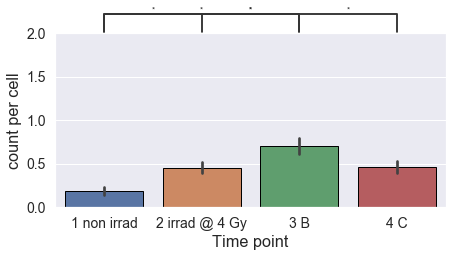

In [702]:
plt.figure(figsize=(7, 3.2))
ax = sns.barplot(x='Time point', y='count per cell', data=inv, 
            order=['1 non irrad', '2 irrad @ 4 Gy', '3 B', '4 C'],)

# ax.set_ylabel('Mean Telomere Length (FISH)', fontsize=18)
# ax.set_xlabel('Time course of client samples', fontsize=18)
ax.tick_params(labelsize=14)
box_pairs = [
    ('1 non irrad', '2 irrad @ 4 Gy'),
    ('1 non irrad', '3 B'),
    ('1 non irrad', '4 C'),
    ('2 irrad @ 4 Gy', '3 B'),
    ('3 B', '4 C'),
]

plt.ylim(0, 2)

add_stat_annotation(ax, data=inv, x='Time point', y='count per cell', 
                    order=['1 non irrad', '2 irrad @ 4 Gy', '3 B', '4 C'],
                    box_pairs=box_pairs,
                    perform_stat_test=False, pvalues=[0.04, 0.04, 0.04, 0.04, 0.04],
                    line_height=0.1, line_offset_to_box=.3, line_offset=.01,
                    test=None, text_format='star', loc='outside', verbose=False, fontsize=16)


# plt.ylim(0, 2)
# plt.savefig('mean telomere length barplot.png', dpi=400, bbox_inches='tight')

In [458]:
trp.chr_scipy_anova_post_hoc_tests(df0=melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'],
                                   post_hoc='tukeyHSD', repeated_measures=True)

# inversions 2.3593983783857947e-16
      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower   upper  reject
-------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  0.2667   0.1365  0.3969  True 
 1 non irrad        3 B        0.5167   0.3865  0.6469  True 
 1 non irrad        4 C        0.2762   0.146   0.4064  True 
2 irrad @ 4 Gy      3 B         0.25    0.1198  0.3802  True 
2 irrad @ 4 Gy      4 C        0.0095  -0.1207  0.1397 False 
     3 B            4 C       -0.2405  -0.3707 -0.1103  True 
-------------------------------------------------------------


# terminal inversions 0.001273355705474978
     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower  upper  reject
------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  0.0929   0.0127 0.173   True 
 1 non irrad        3 B        0.1095   0.0294 0.1896  

In [33]:
# pivoting out aberrations for linear regression

group_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()
pivot_chr = group_chr.pivot(index='patient id', columns='timepoint', values='# inversions')

In [34]:
row = []
aberr_types = [col for col in group_chr.columns if col != 'patient id' and col != 'timepoint']

for aberr in aberr_types:
    pivot_chr = group_chr.pivot(index='patient id', columns='timepoint', values=aberr)
    x_name2 = ['1 non irrad']
    x_name3 = ['2 irrad @ 4 Gy', '1 non irrad']
    y_name = '4 C'

#     print(f'ABERRATION TYPE | {aberr}')
    for x_name in [x_name2, x_name3]:
        x = pivot_chr[x_name].values.reshape(-1, len(x_name))
        y = pivot_chr['4 C'].values.reshape(-1, 1)

        regression = LinearRegression().fit(x, y)
#         print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")
#         print('\n')
        row.append(['Linear Regression', aberr, x_name, y_name, f'{regression.score(x, y):.4f}'])
    
LM_aberr_r2 = pd.DataFrame(data=row, columns=['Model', 'Aberration type', 'Variables', 'Target', 'R2 score'])

In [35]:
LM_aberr_r2

,Model,Aberration type,Variables,Target,R2 score
0,Linear Regression,# inversions,[1 non irrad],4 C,0.2348
1,Linear Regression,# inversions,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.2875
2,Linear Regression,# terminal inversions,[1 non irrad],4 C,0.0002
3,Linear Regression,# terminal inversions,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.0020
4,Linear Regression,# sister chromatid exchanges,[1 non irrad],4 C,0.4492
5,Linear Regression,# sister chromatid exchanges,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.5054
6,Linear Regression,# dicentrics,[1 non irrad],4 C,0.0000
7,Linear Regression,# dicentrics,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.5138
8,Linear Regression,excess chr fragments,[1 non irrad],4 C,0.0904
9,Linear Regression,excess chr fragments,"[2 irrad @ 4 Gy, 1 non irrad]",4 C,0.1771
